# Logistic Regression
By Josh Houlding

It is important to have experience implementing one of the most common applications of regression currently used in business, finance, and healthcare. Questions like should a loan be approved, is a driver entitled a discount, and will a patient survive are all answered with a form of logistic regression (i.e., with a Yes/No answer).

Using a dataset representing applications for a bank loan, the task will be to build a logistic regression model that can predict whether or not a loan will be approved.

<b>Assignment Instructions:</b> <a href="https://halo.gcu.edu/courses/DSC-520-O500-20240125#assignment-submission/810cad63-ea85-4f43-9850-32f21dfc0772">https://halo.gcu.edu/courses/DSC-520-O500-20240125#assignment-submission/810cad63-ea85-4f43-9850-32f21dfc0772</a><br>
<b>Dataset: </b><a href="https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction">Credit Card Approval Prediction | Kaggle</a>

For this activity, perform the following:

### Task 1
Load the "application_record.csv," located in the topic Resources, into a data frame and perform initial exploratory tasks:
* Display representative portions of the data.<br>
* Check for missing values and clean the data.<br>
* Check for outliers and decide if and how to process them.<br>
* Formally state what your model will predict using the variables in the data. <hr>

<b>Display representative portions of the data.</b>

In [419]:
# Import basic libraries
import pandas as pd
import numpy as np
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Import modeling libraries
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Import encoding libraries
from sklearn.preprocessing import LabelEncoder

# Import diagnostic libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [420]:
# Load and view data
df = pd.read_csv("application_record.csv")
print(f"Total rows: {len(df)}")
df.head()

Total rows: 438557


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [421]:
# Rename columns
new_column_mapping = {"ID": "id", "CODE_GENDER": "gender", "FLAG_OWN_CAR": "owns_car", "FLAG_OWN_REALTY": "owns_realty", 
                      "CNT_CHILDREN": "children", "AMT_INCOME_TOTAL": "income", "NAME_INCOME_TYPE": "income_type", 
                      "NAME_EDUCATION_TYPE": "education_type", "NAME_FAMILY_STATUS": "family_status",
                      "NAME_HOUSING_TYPE": "housing_type", "DAYS_BIRTH": "age_in_days", "DAYS_EMPLOYED": "days_employed",
                      "FLAG_MOBIL": "has_mobile_phone", "FLAG_WORK_PHONE": "has_work_phone", "FLAG_PHONE": "has_phone",
                      "FLAG_EMAIL": "has_email", "OCCUPATION_TYPE": "occupation_type", "CNT_FAM_MEMBERS": "family_size"}

df.rename(columns=new_column_mapping, inplace=True)

# Convert "id" to int
df["id"] = df["id"].astype(int)

# Convert "age_in_days" to positive values
df["age_in_days"] = df["age_in_days"].abs()

# Invert values of "days_employed"
df["days_employed"] = df["days_employed"] * -1

In [422]:
# Load credit_record.csv
credit_record = pd.read_csv("credit_record.csv")

In [423]:
# Rename columns
new_column_mapping = {"ID": "id", "MONTHS_BALANCE": "months_balance", "STATUS": "status"}
credit_record.rename(columns=new_column_mapping, inplace=True)
credit_record.head()

,id,months_balance,status
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


* `months_balance`: The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
* `status`: 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

We see that there are several entries for each id, and if we are to join this dataframe of credit records with the original, we must only select the entries for the current month (`months_balance` = 0). 

In [424]:
# Filter credit_record down to only the current month
credit_record = credit_record[credit_record["months_balance"] == 0]
credit_record.head()

,id,months_balance,status
0,5001711,0,X
4,5001712,0,C
23,5001713,0,X
45,5001714,0,X
60,5001715,0,X


In [425]:
# Find number of customers with current monthly status
print("Total rows:", len(credit_record["id"].unique()))

Total rows: 33856


Now, we can join the `credit_record` dataframe with the original to get the `status` column, which we will use as the label in the model. Because there are substantially less customers with current monthly statuses than there are in the original dataframe, we are forced to accept a significant loss of data, which could affect the accuracy of the model. 

In [426]:
# Join the two dataframes
df = pd.merge(df, credit_record[["id", "status"]], on="id", how="left")

# Drop id column that is no longer needed
df = df.drop(columns={"id"})

In [427]:
# Show 5 random rows of data
df.sample(5, random_state=42)

,gender,owns_car,owns_realty,children,income,income_type,education_type,family_status,housing_type,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,occupation_type,family_size,status
284481,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,23010,-365243,1,0,0,0,NaN,1.0,NaN
203727,F,N,Y,1,81000.0,Working,Secondary / secondary special,Married,House / apartment,16812,1094,1,1,0,0,Sales staff,3.0,NaN
233631,M,N,Y,1,189000.0,Working,Secondary / secondary special,Married,House / apartment,13516,1312,1,0,0,0,NaN,3.0,NaN
7505,M,N,Y,0,360000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,12483,4039,1,0,0,0,Managers,2.0,C
192047,F,Y,Y,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,21220,-365243,1,0,0,0,NaN,2.0,NaN


Updated `age_in_days` and `days_employed` meanings: 
* `age_in_days` is now a positive number indicating how many days have elapsed since the person was born. 
* `days_employed` is now a positive number indicating how many days the person has been employed, or a negative number indicating how many days the person has been unemployed for. 

<b>Check for missing values and clean the data.</b>

In [428]:
# Find missing value count
print(f"Rows with missing values: {len(df[df.isna().any(axis=1)])}")

Rows with missing values: 421514


In [429]:
# Fill in missing values (mode for categorical columns, mean or median for numeric columns)
df["gender"].fillna(df["gender"].mode()[0], inplace=True)
df["owns_car"].fillna(df["owns_car"].mode()[0], inplace=True)
df["owns_realty"].fillna(df["owns_realty"].mode()[0], inplace=True)
df["children"].fillna(df["children"].median(), inplace=True)
df["income"].fillna(df["income"].median(), inplace=True)
df["income_type"].fillna(df["income_type"].mode()[0], inplace=True)
df["education_type"].fillna(df["education_type"].mode()[0], inplace=True)
df["family_status"].fillna(df["family_status"].mode()[0], inplace=True)
df["housing_type"].fillna(df["housing_type"].mode()[0], inplace=True)
df["age_in_days"].fillna(df["age_in_days"].median(), inplace=True)
df["days_employed"].fillna(df["days_employed"].median(), inplace=True)
df["has_mobile_phone"].fillna(df["has_mobile_phone"].mode()[0], inplace=True)
df["has_work_phone"].fillna(df["has_work_phone"].mode()[0], inplace=True)
df["has_phone"].fillna(df["has_phone"].mode()[0], inplace=True)
df["has_email"].fillna(df["has_email"].mode()[0], inplace=True)

# Fill in missing "occupation_type" values with a random selection from the 3 most popular occupation types
most_popular_occupation_types = ["Laborers", "Core staff", "Sales staff"]
def fill_missing_occupation(row): 
    if(pd.isna(row["occupation_type"])): 
        return random.choice(most_popular_occupation_types)
    else:
        return row["occupation_type"]
df["occupation_type"] = df.apply(fill_missing_occupation, axis=1)

# Drop rows with missing "status" values
df = df.dropna()

In [430]:
print(f"Rows with missing values: {len(df[df.isna().any(axis=1)])}")

Rows with missing values: 0


<b>Check for outliers and decide if and how to process them.</b>

In [431]:
# Check descriptive statistics for "income"
df["income"].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
income,24672.0,187074.991488,102094.831348,27000.0,121500.0,157500.0,225000.0,1575000.0


The lowest income is <span>&dollar;27,000</span>, the highest income is <span>&dollar;1575000</span> (plausible for a CEO), and the mean income is ~<span>&dollar;187,000</span>. These seem like reasonable numbers. Let's check how many applicants make over <span>&dollar;1 million</span>, <span>&dollar;500k</span>, and <span>&dollar;250k</span>. 

In [432]:
applicants_over_1mil = len(df[df["income"] > 1000000])
applicants_over_500k = len(df[df["income"] > 500000])
applicants_over_250k = len(df[df["income"] > 250000])

print(f"Applicants making over $1 million: {applicants_over_1mil}")
print(f"Applicants making over $500k: {applicants_over_500k}")
print(f"Applicants making over $250k: {applicants_over_250k}")

Applicants making over $1 million: 11
Applicants making over $500k: 324
Applicants making over $250k: 4527


We see that less than 20% of applicants make over <span>&dollar;250k</span>, and a very small number make over <span>&dollar;500k</span> or <span>&dollar;1 million.</span> Thus, these high-income entries should not be a problem, and nothing needs to be done about outliers for this column. 

In [433]:
# Check descriptive statistics for "age_in_days"
df["age_in_days"].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
age_in_days,24672.0,16022.503161,4181.750665,7489.0,12541.75,15653.0,19453.0,25152.0


The oldest applicant is about 69 years old, the youngest is 20, and the average applicant is about 44. Again, these are reasonable numbers, so nothing needs to be handled for this column either. 

In [434]:
# Check descriptive statistics for "days_employed"
df["days_employed"].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
days_employed,24672.0,-58970.168126,137408.898862,-365243.0,401.0,1546.0,3170.0,15713.0


We see that the longest an applicant has been unemployed for is over 1,000 years, which is absurd. Let's see how many times this $-365243$ value is repeated. 

In [435]:
len(df[df["days_employed"] == -365243])

4133

This specific value is present in almost 20% of entries, and must be corrected. Let's replace it with values taken from a normal distribution of `days_employed`. 

In [436]:
# Replace -365243 values for "days_employed"
unrealistic_values = df["days_employed"] == -365243
mean_days_employed = df.loc[~unrealistic_values, "days_employed"].mean()
std_days_employed = df.loc[~unrealistic_values, "days_employed"].std()

np.random.seed(42)
df["days_employed"] = np.where(unrealistic_values, np.random.normal(loc=mean_days_employed, scale=std_days_employed, size=df.shape[0]), df["days_employed"])

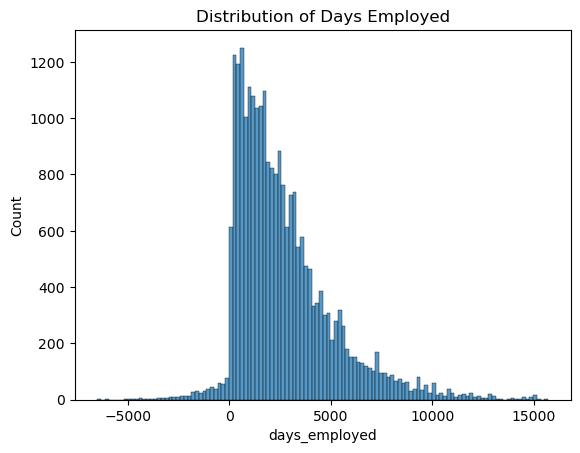

In [437]:
# View distribution of "days_employed"
sns.histplot(df["days_employed"])
plt.title("Distribution of Days Employed")
plt.show()

In [438]:
df.head(1)

,gender,owns_car,owns_realty,children,income,income_type,education_type,family_status,housing_type,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,occupation_type,family_size,status
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542.0,1,1,0,0,Core staff,2.0,C


In [439]:
# View descriptive statistics for "family_size"
median = df["family_size"].median()
print(f"Median: {median}")
df["family_size"].describe().to_frame().transpose()

Median: 2.0


,count,mean,std,min,25%,50%,75%,max
family_size,24672.0,2.184257,0.912098,1.0,2.0,2.0,3.0,20.0


We see about what we would expect, with a mean family size just above 2, a median at 2, and a minimum at 1 (for people living on their own). The only surprise is the max at 20, which seems like an absurdly large family. Suppose the maximum reasonable family size is 10. Let's see how many families are larger than that. 

In [440]:
len(df[df["family_size"] > 10])

4

Only 4 out of over 438,000 people have families larger than 10 people, so these outliers should have a negligible effect on the analysis. 

<b>Formally state what your model will predict using the variables in the data.</b>

Using the variables in the data, my model will predict whether a customer's credit card application should be accepted or rejected.

<b>Prepare the data for modeling.</b>

Next, we will make every predictor numeric with dummy variables and label encoding, then normalize the data. These two steps will make the data suitable for modeling. 

In [441]:
# Show data before dummy and label encoding
df.head(1)

,gender,owns_car,owns_realty,children,income,income_type,education_type,family_status,housing_type,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,occupation_type,family_size,status
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542.0,1,1,0,0,Core staff,2.0,C


In [442]:
# Dummify "gender", "income_type", "education_type", "family_status", "housing_type", and "occupation_type"
df = pd.get_dummies(df, columns=["gender", "income_type", "education_type", "family_status", "housing_type", "occupation_type"])

# Convert dummified columns to int datatype
for col in df.columns: 
    if df[col].dtype == "bool": 
        df[col] = df[col].astype(int)

# Apply label encoding to "owns_car","owns_realty" and "status"
label_encoder = LabelEncoder()
df["owns_car"] = label_encoder.fit_transform(df["owns_car"])
df["owns_realty"] = label_encoder.fit_transform(df["owns_realty"])
df["status"] = label_encoder.fit_transform(df["status"])
df["status"] = df["status"].astype(int)

After performing label encoding, `status` has the following modifications:
* "C" changed to 6
* "X" changed to 7

We now need to convert these values into 0 or 1 so logistic regression can be run on the data. We will consider customers who have outstanding debt (1-5) to be rejected (0), and those who have paid off their debt that month or haven't taken a loan to be approved (1). 

In [443]:
# Convert "status" to binary values
df["status"] = np.where(df["status"] <= 5, 0, df["status"])
df["status"] = np.where(df["status"] > 5, 1, df["status"])

In [444]:
# Show final result of dummification and label encoding
df.head(1)

,owns_car,owns_realty,children,income,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,...,occupation_type_Laborers,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Waiters/barmen staff
0,1,1,0,427500.0,12005,4542.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that all predictor variables are numeric, we must normalize them for modeling. 

In [445]:
df.head(1)

,owns_car,owns_realty,children,income,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,...,occupation_type_Laborers,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Waiters/barmen staff
0,1,1,0,427500.0,12005,4542.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [446]:
# Normalize non-binary numeric variables
status = df.pop("status")
scaler = MinMaxScaler()
columns_to_normalize = ["children", "income", "age_in_days", "days_employed", "family_size"]
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Move label "status" to the end of the dataframe
df["status"] = status

# Show final dataframe for modeling
df.head(1)

,owns_car,owns_realty,children,income,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,...,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Waiters/barmen staff,status
0,1,1,0.0,0.258721,0.255676,0.496994,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Data is now ready for modeling.

### Task 2
Split the data into a training set and a testing set with a split ratio of 70:30.<hr>

In [447]:
# Define features and target
x = df.drop("status", axis=1)
y = df["status"]

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Show the shapes of training and testing sets
print(f"Shape of x_train: {x_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}, Shape of y_test: {y_test.shape}")

Shape of x_train: (17270, 52), Shape of y_train: (17270,)
Shape of x_test: (7402, 52), Shape of y_test: (7402,)


Our data is now ready to be fed into the model.

### Task 3
Build the Predictive Model:
* Define the formula for the glm().
* Run the model.
* Interpret the results, referring to the p-values.<hr>

<b>Define the formula for the glm().</b>

The GLM formula for the model takes the form of a logistic function in this general form:<br><br>
$logit(p) = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n$.

* $logit(p)$: The log-odds of the probability of the event occurring. 
* $\beta_0$: The y-intercept term. 
* $\beta_1, \beta_2, ...,\beta_n$: The coefficients associated with each predictor variable $X_1, X_2, ..., X_n$. 

<b>Run the model.</b>

I ran into numerous multicollinearity issues when trying to run the model, so we will check the VIFs and drop variables with high VIFs before modeling. 

In [448]:
# Function to drop variables with high VIFs 
def drop_high_vif_variables(data_frame, threshold=5):
    features = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    high_vif_variables = vif_data[vif_data["VIF"] > threshold]["Variable"].values
    data_frame_dropped = data_frame.drop(high_vif_variables, axis=1)
    return data_frame_dropped

# Drop variables with high VIFs from the dataframe
df = drop_high_vif_variables(df)

C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [449]:
df.head(0)

,owns_car,owns_realty,income,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,status


We find that most of the variables (~80%) have been removed safely due to having very high VIFs. These include anything related to occupation, family size, and gender, to name a few. 

Let's look at a correlation matrix and see if we can learn anything interesting. 

In [450]:
# View correlation matrix
df.corr()

,owns_car,owns_realty,income,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,status
owns_car,1.000000,-0.014365,0.219793,-0.151526,-0.056990,NaN,0.020158,-0.017210,0.021079,0.005491
owns_realty,-0.014365,1.000000,0.043211,0.132943,0.010331,NaN,-0.219194,-0.072748,0.055523,-0.010532
income,0.219793,0.043211,1.000000,-0.066397,0.010613,NaN,-0.031761,0.017546,0.093420,-0.009696
age_in_days,-0.151526,0.132943,-0.066397,1.000000,0.237794,NaN,-0.180922,0.030627,-0.105493,-0.004866
days_employed,-0.056990,0.010331,0.010613,0.237794,1.000000,NaN,0.008204,0.045896,-0.041877,0.018518
has_mobile_phone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_work_phone,0.020158,-0.219194,-0.031761,-0.180922,0.008204,NaN,1.000000,0.303945,-0.031652,0.011358
has_phone,-0.017210,-0.072748,0.017546,0.030627,0.045896,NaN,0.303945,1.000000,0.014730,0.000563
has_email,0.021079,0.055523,0.093420,-0.105493,-0.041877,NaN,-0.031652,0.014730,1.000000,-0.009844
status,0.005491,-0.010532,-0.009696,-0.004866,0.018518,NaN,0.011358,0.000563,-0.009844,1.000000


We see that `has_mobile_phone` is all NaN correlation values, which is suspicious. Let's look at the value counts for this variable. 

In [451]:
df["has_mobile_phone"].value_counts()

has_mobile_phone
1    24672
Name: count, dtype: int64

All values for this variable are 1, so it has no predictive power and thus should also be removed. 

In [452]:
df.head(0)

,owns_car,owns_realty,income,age_in_days,days_employed,has_mobile_phone,has_work_phone,has_phone,has_email,status


In [453]:
# Remove "has_mobile_phone"
df = df.drop(columns={"has_mobile_phone"})
df = df.reset_index(drop=True)

In [454]:
df.head(0)

,owns_car,owns_realty,income,age_in_days,days_employed,has_work_phone,has_phone,has_email,status


Now, our model equation looks like this: 
$status = \beta_0 + \beta_1 * ownscar + \beta_2 * ownsrealty + \beta_3 * income + \beta_4 * ageindays + \beta_5 * daysemployed + \beta_6 * hasworkphone + \beta_7 * hasphone + \beta_8 * hasemail$

Additionally, because we have modified the dataframe by removing variables with high VIFs, we need to redo the train-test split. 

In [455]:
# Redo train-test split with updated dataframe
# Define features and target
x = df.drop("status", axis=1)
y = df["status"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Show the shapes of training and testing sets
print(f"Shape of x_train: {x_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}, Shape of y_test: {y_test.shape}")
print()

# Train model
x_train = sm.add_constant(x_train)
model = sm.Logit(y_train, x_train)
result = model.fit()

# Reset y indices
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Add constant to x_test for prediction
x_test = sm.add_constant(x_test)

# Compare actual vs. predicted values
predicted_status = result.predict(x_test)
threshold = 0.5
predicted_status = (predicted_status > threshold).astype(int)

Shape of x_train: (17270, 8), Shape of y_train: (17270,)
Shape of x_test: (7402, 8), Shape of y_test: (7402,)

Optimization terminated successfully.
         Current function value: 0.604352
         Iterations 5


<b>Interpret the results, referring to the p-values.</b>

In [456]:
# Display summary
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                17270
Model:                          Logit   Df Residuals:                    17261
Method:                           MLE   Df Model:                            8
Date:                Wed, 06 Mar 2024   Pseudo R-squ.:               0.0008420
Time:                        14:55:51   Log-Likelihood:                -10437.
converged:                       True   LL-Null:                       -10446.
Covariance Type:            nonrobust   LLR p-value:                   0.02451
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7813      0.081      9.703      0.000       0.623       0.939
owns_car           0.0662      0.036      1.850      0.064      -0.004       0.136
owns_realty       -0.0203      0.037

We see that whether someone owns a car, how long they've been employed, and whether they have a work phone are all positively correlated with their application being accepted, whereas all other variables in the model negatively affect one's chances. 

However, it should also be noted that every variable except `days_employed` has a $P>|z|$ value greater than $\alpha = 0.05$, suggesting that they might not be statistically significant. 

### Task 4
Evaluate the Model Performance: 
* Compare the predicted versus actual values.
* Search for any predictions that differ significantly from the actual values. 

In [457]:
# Compare actual values to predictions
actual_status = y_test
predicted_status.reset_index(drop=True, inplace=True)
actual_vs_predicted = pd.DataFrame({
    "actual_status": actual_status, 
    "predicted_status": predicted_status
})

num_wrong_predictions = len(actual_vs_predicted[actual_vs_predicted["actual_status"] != actual_vs_predicted["predicted_status"]])
total_predictions = len(actual_vs_predicted)
percentage_correct = round((total_predictions - num_wrong_predictions) / total_predictions, 2) * 100

print(f"Total number of predictions: {total_predictions}")
print(f"Number of correct predictions: {total_predictions - num_wrong_predictions}")
print(f"Percentage of correct predictions: {percentage_correct}%")

Total number of predictions: 7402
Number of correct predictions: 5252
Percentage of correct predictions: 71.0%


We achieve a precision value of 71% with this model, meaning that out of all predictions made, 71% were correct. 

### Task 5
Validate the Model: 
* Produce a Gain and Lift chart and use it to describe the performance of the model.
* Measure the Variation Inflation Factor (VIF) to test for multicollinearity. If changes are necessary to the model based in VIF, state and implement them.
* Has the formula, as defined in the previous section, changed? Why or why not?
* If changes to the model occurred, repeat the validation steps on the new model.

<b>Produce a Gain and Lift chart and use it to describe the performance of the model.</b> 

In [458]:
# Get predicted probabilities
predicted_probs = result.predict(x_test)
indices = np.argsort(predicted_probs)

# Sort actual values and predicted probabilities
y_test_sorted = y_test.iloc[indices]
predicted_probs_sorted = predicted_probs.iloc[indices]

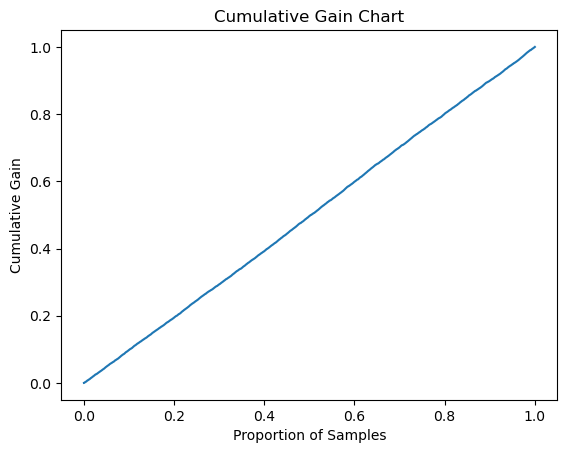

In [459]:
# Calculate cumulative gain 
cumulative_gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)

# Plot gain chart
plt.plot(np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted), cumulative_gain, label="Gain Chart")
plt.title("Cumulative Gain Chart")
plt.xlabel("Proportion of Samples")
plt.ylabel("Cumulative Gain")
plt.show()

The gain chart shows a perfect linear trend with what appears to be a slope of 1, indicating that the model is no better than random selection. 

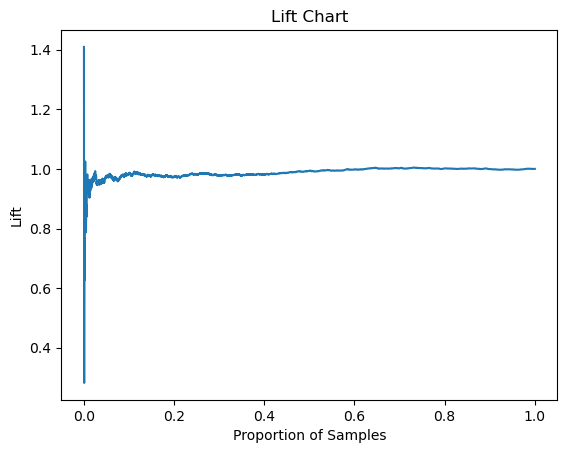

In [460]:
# Calculate lift
lift = cumulative_gain / (np.arange(len(y_test_sorted)) / len(y_test_sorted))

# Plot lift chart 
plt.plot(np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted), lift, label="Lift Chart")
plt.title("Lift Chart")
plt.xlabel("Proportion of Samples")
plt.ylabel("Lift")
plt.show()

Just like with the cumulative gain chart, the lift chart shows that the model is no better than random selection with its convergence to 1. 

Both of these charts show that model improvement is necessary for elevating its predictive power above random selection. 

<b>Measure the Variation Inflation Factor (VIF) to test for multicollinearity. If changes are necessary to the model based in VIF, state and implement them.</b>

This was already done earlier, and about 80% of the predictor variables were removed, leading to a much more concise model.

<b>Has the formula, as defined in the previous section, changed? Why or why not?</b>

The formula was changed drastically by removing any predictor variables with a VIF above 10, leading to its shortening from 52 predictors down to 9. This is the current formula: 

$status = \beta_0 + \beta_1 * ownscar + \beta_2 * ownsrealty + \beta_3 * income + \beta_4 * ageindays + \beta_5 * daysemployed + \beta_6 * hasworkphone + \beta_7 * hasphone + \beta_8 * hasemail$

And these are the predictor variables involved: 

In [464]:
df.drop(columns={"status"}).head(0)

,owns_car,owns_realty,income,age_in_days,days_employed,has_work_phone,has_phone,has_email


<b>If changes to the model occurred, repeat the validation steps on the new model.</b>

The model was changed before validation steps were applied, so no new validation is currently necessary. 

### Task 6
* Demonstrate a few examples of predictions your model can make.
* Validate the predictions by calculating the misclassification error.
* Interpret the results.

<b>Demonstrate a few examples of predictions your model can make.</b>

In [461]:
# Generate synthetic data for demonstration
np.random.seed(42)
n = 100000

synthetic_data = {
    "owns_car": np.random.randint(2, size=n), 
    "owns_realty": np.random.randint(2, size=n), 
    "income": np.abs(np.random.normal(0, 1, size=n)), 
    "age_in_days": np.abs(np.random.normal(0, 1, size=n)), 
    "days_employed": np.abs(np.random.normal(0, 1, size=n)), 
    "has_work_phone": np.random.randint(2, size=n), 
    "has_phone": np.random.randint(2, size=n), 
    "has_email": np.random.randint(2, size=n), 
    "status": np.random.randint(2, size=n)
}

demo_df = pd.DataFrame(synthetic_data)

# Normalize relevant variables
vars_to_normalize = ["income", "age_in_days", "days_employed"]
demo_df[vars_to_normalize] = scaler.fit_transform(demo_df[vars_to_normalize])

# Make predictions
x = demo_df.drop(columns={"status"})
demo_df["predicted_status"] = result.predict(demo_df)

# Convert predicted column to binary values
demo_df.rename(columns={"predicted_status": "prob_of_approval"}, inplace=True)
demo_df["predicted_status"] = round(demo_df["prob_of_approval"])
demo_df["predicted_status"] = demo_df["predicted_status"].astype(int)

demo_df.sample(5)

,owns_car,owns_realty,income,age_in_days,days_employed,has_work_phone,has_phone,has_email,status,prob_of_approval,predicted_status
65982,0,1,0.085527,0.094413,0.434060,0,0,0,1,0.486023,0
93244,0,0,0.044386,0.037371,0.024281,0,0,0,0,0.494703,0
33080,1,0,0.152498,0.202990,0.418580,1,1,0,0,0.756796,1
15416,0,1,0.012316,0.218161,0.160565,0,0,1,0,0.476843,0
83596,1,0,0.082312,0.018620,0.042294,0,1,1,0,0.686564,1


<b>Validate the predictions by calculating the misclassification error.</b>

In [462]:
# Calculate misclassification error
total_predictions = len(demo_df)
incorrect_predictions = len(demo_df[demo_df["predicted_status"] != demo_df["status"]])
misc_proportion = round(incorrect_predictions / total_predictions, 2)
misc_percent = misc_proportion * 100
print(f"Misclassification Error: {misc_percent}%")

Misclassification Error: 52.0%


We see a misclassification error of about 50%, which is about what we would see by guessing randomly. Therefore, the model unfortunately turns out to be no better than random guessing. 

### Task 7
State a few suggestions for improving the model.

* Training the model on more data could have substantially improved it, but 95% of the total data was lost during the merging of the two CSV files, meaning that the model is nowhere near as accurate as it could be. More data would have surely made its predictions more accurate. 
* More care could have been taken to avoid overfitting the model to the training data. This problem is especially likely with such a small training set like I ended up with. 
* I could have planned out the data prep and cleaning process more methodically to minimize data loss, which would have then led to a more accurate model, as mentioned earlier. 

### References
Tim. (2022, February 28). Gain and Lift Chart: Definition, Example - Statistics How to. Statistics How To. https://www.statisticshowto.com/lift-chart-gain/<br>
ChatGPT. (n.d.). https://chat.openai.com/<br>
Bing AI - Bing. (n.d.-a). Bing. https://www.bing.com/search?toncp=0&FORM=hpcodx&q=Bing+AI&showconv=1